In [56]:
# Bibliotecas necesarias para operaciones numéricas y análisis y manipulación de datos
import numpy as np
import pandas as pd

import openpyxl # Biblioteca para leer archivos de Excel

# Biblioteca para procesamiento de lenguaje natural y dividir texto en palabras.
import nltk
from nltk.tokenize import word_tokenize

# Biblioteca para crear y visualizar gráficos y datos estadísticos 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Herramienta para convertir etiquetas en números, transformar y normalizar datos y 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential # Clase para construir modelos de redes neuronales
from tensorflow.keras import layers  # Módulo para definir capas en la red neuronal
from tensorflow.keras.optimizers import Adam  # Optimizador para ajustar la tasa de aprendizaje
from tensorflow.keras import metrics  # Módulo para métricas de evaluación en modelos de keras

In [57]:
# Se carga el archivo CSV en un DataFrame
df = pd.read_csv('/Users/memobarbosa/Downloads/HackMX2024/df_final.csv')

# Se filtra el DataFrame para mantener solo los registros de los años 2020 a 2024
df = df[(df['year']>=2020) & (df['year'] <=2024)]

# RNN 1

In [67]:
# Se excluye 'fecha_hecho' (datetime)
rnn_cols = df.drop(["fecha_hecho"], axis=1).columns

# Se define a las variables independientes (X) excluyendo columnas no necesarias
X = df.drop(['fecha_hecho', 'tipo_delito', 'delito', 'categoria_delito', 'IDS_AdecEnergetica', 'IDS_SeguridadSocial',
             'IDS_BienesDurables', 'IDS_Telecomunicaciones', 'IDS_Salud', 'IDS_AdecSanitaria', 'Estado_IDS'], axis=1)
# Se define la variable dependiente (y) que contiene el tipo de delito
y = df['tipo_delito']

# Se crea un codificador OneHot para convertir la variable 'tipo_delito' en formato numérico, para ambos sets, y ajustado a los valores de y
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.values.reshape(-1, 1))

# 70% de los datos (2020-2024) para el entrenamiento
train_len = int(round(df.shape[0] * .7,0))

# Se define el número de pasos de tiempo
time_steps = 12

# Se divide a los datos en conjuntos de entrenamiento (70%) y prueba (30%)
X_train = X.iloc[:train_len][['hora_hecho', 'es_fin_de_semana', 'es_cercano_a_quincena']]
y_train = y.iloc[:train_len]
X_test = X.iloc[train_len:][['hora_hecho', 'es_fin_de_semana', 'es_cercano_a_quincena']]
y_test = y.iloc[train_len:]

# Se codifican las etiquetas de entrenamiento y prueba en formato OneHot
y_train_one_hot = encoder.transform(y_train.values.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.values.reshape(-1, 1))

In [81]:
# Se crea un StandardScaler para normalizar los datos
scaler = StandardScaler()

# Se normalizan los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train).reshape(-1, X_train.shape[-1])
X_test_scaled = scaler.transform(X_test).reshape(-1, X_test.shape[-1])

# Se define una función para crear un conjunto de datos con ventanas de tiempo
def create_dataset(data, labels, time_steps):
    Xs, ys = [], [] # Se inicializan listas para almacenar las entradas y salidas

    # Se crea un pad que agrega 0s para completar / acomodar los time_steps
    pad_width = time_steps - 1 # Ancho del padding
    # Se agrega el padding a los datos
    padded_data = np.pad(data, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

    # Se itera sobre los datos para crear las ventanas de tiempo
    for i in range(len(data)):
        Xs += [padded_data[i:i + time_steps]] # Agregamos los valores de la ventana de input a los valores del array de X
        ys += [labels[i]] # Agregamos las etiquetas (tipos de delitos) sin cambios

    return np.array(Xs), np.array(ys) # Se devuelven los arrays como numpy arrays

# Longitud original y final (tras normalización) de los datos de entrenamiento
print(f"Original length of training data: {len(X_train)}, {len(y_train)}")
X_train_rnn, y_train_rnn = create_dataset(X_train_scaled, y_train_one_hot, time_steps) # Conjuntos de datos de entrenamiento para la red neuronal
print(f"Final length of training data: {len(X_train_rnn)}, {len(y_train_rnn)}")

# Longitud original y final (tras normalización) de los datos de prueba
print(f"\nOriginal length of test data: {len(X_test)}, {len(y_test)}")
X_test_rnn, y_test_rnn = create_dataset(X_test_scaled, y_test_one_hot, time_steps) # Conjuntos de datos de prueba para la red neuronal
print(f"Final length of training data: {len(X_test_rnn)}, {len(y_test_rnn)}")

# Se revisan los valores de cada y
print("\nUnique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

# 70% de los datos (2020-2024) para el entrenamiento
split_index = int(0.7 * len(X_train_rnn))

# Se separan los datos de entrenamiento en conjuntos de entrenamiento y validación
X_train_split = X_train_rnn[:split_index]
y_train_split = y_train_rnn[:split_index]
# 30% restante para validación
X_val = X_train_rnn[split_index:]
y_val = y_train_rnn[split_index:]

Original length of training data: 138016, 138016
Final length of training data: 138016, 138016

Original length of test data: 59150, 59150
Final length of training data: 59150, 59150

Unique values in y_train: [  1   2   3   4   5   6   8   9  10  12  15  16  17  19  20  22  23  24
  25  28  29  30  33  34  35  36  39  40  44  45  46  47  48  49  50  51
  52  54  57  59  61  63  64  66  67  68  70  71  72  76  77  81  82  84
  85  87  89  90  91  92  95  96  98 101 102 103 105 106]
Unique values in y_test: [  1   2   3   4   5   6   8  10  12  15  16  19  20  21  22  23  24  25
  27  28  29  30  32  33  34  35  37  38  39  41  42  43  45  46  47  48
  49  50  51  52  53  54  59  60  61  63  64  65  66  67  68  69  70  71
  72  73  75  76  77  79  80  82  84  87  88  89  90  91  92  94  95  96
  97  98  99 101 102 103 105 106 107]


In [82]:
# Se define una función para crear un modelo de Red Neuronal Recurrente (RNN)
def create_RNN(hidden_units, dense_units, input_shape, activation):
    # Modelo secuencial
    model = Sequential([layers.Input(shape=input_shape,)])

    # Primera capa RNN con unidades ocultas y función de activación
    model.add(layers.SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
    # Segunda capa RNN, que también utiliza las mismas unidades ocultas y función de activación
    model.add(layers.SimpleRNN(hidden_units, activation=activation[0]))
    # Capa densa final, que produce la salida del modelo
    model.add(layers.Dense(units=dense_units, activation=activation[1]))

    # Optimizador Adam con una tasa de aprendizaje de 0.001
    optimizer = Adam(learning_rate=0.001) # learning rate 0.001

    # Compilación del modelo especificando la función de pérdida, el optimizador y las métricas a utilizar
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
    return model

In [84]:
# No. de características de entrada de los datos de entrenamiento
features = X_train_rnn.shape[2]

# Modelo de RNN utilizando la función definida previamente
model = create_RNN(hidden_units=3, dense_units=y_train_one_hot.shape[1],
                   input_shape=(time_steps, features), activation=['tanh', 'softmax'])

# Se entrena el modelo con los datos de entrenamiento (datos de entrada, etiquetas, num. épocas,
#                                                      tamaño del lote, nivel de detalle de la salida en consola,
#                                                      datos de validación para evaluar el modelo)
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.4056 - loss: 3.2504 - val_categorical_accuracy: 0.4985 - val_loss: 2.0732
Epoch 2/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5345 - loss: 1.9774 - val_categorical_accuracy: 0.4985 - val_loss: 2.0586
Epoch 3/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5360 - loss: 1.9537 - val_categorical_accuracy: 0.4985 - val_loss: 2.0560
Epoch 4/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5316 - loss: 1.9681 - val_categorical_accuracy: 0.4985 - val_loss: 2.0543
Epoch 5/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5339 - loss: 1.9665 - val_categorical_accuracy: 0.4985 - val_loss: 2.0528
Epoch 6/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5324 - loss: 1.9624 - val_categorical_accuracy: 0.4985 - val_loss: 2.0544
Epoch 7/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_a

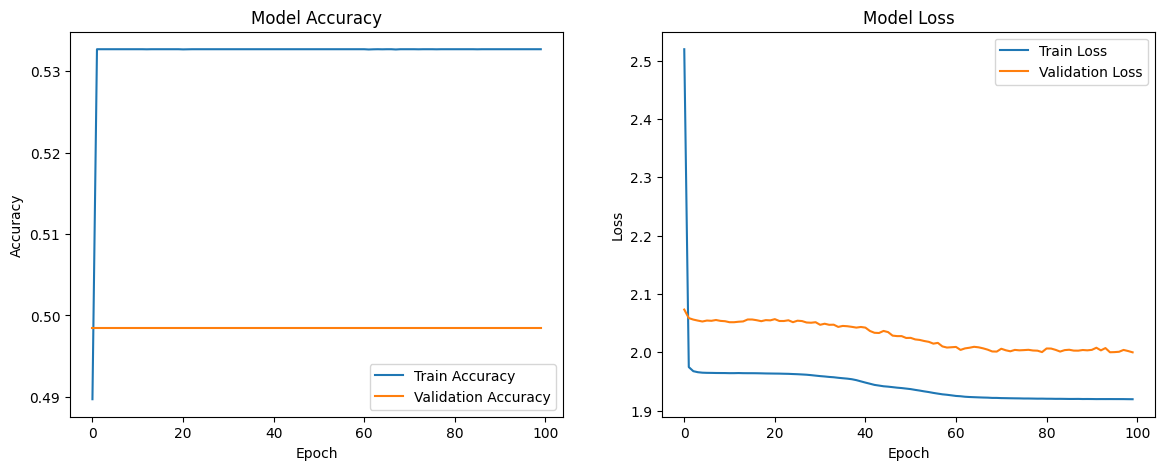

In [86]:
# Figura para visualizar la precisión y la pérdida del modelo durante el entrenamiento
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1) # primer subplot para la precisión del modelo
# precisión de entrenamiento y de la validación
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# segundo subplot para la pérdida del modelo
plt.subplot(1, 2, 2)
# pérdida de entrenamiento y validación
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# RNN2

In [91]:
rnn_cols = df.drop(["fecha_hecho"], axis=1).columns

X = df.drop(['fecha_hecho', 'tipo_delito', 'delito', 'categoria_delito', 'IDS_AdecEnergetica', 'IDS_SeguridadSocial',
             'IDS_BienesDurables', 'IDS_Telecomunicaciones', 'IDS_Salud', 'IDS_AdecSanitaria', 'Estado_IDS'], axis=1)
y = df['tipo_delito']

# 70% de los datos (2020-2024) para el entrenamiento
train_len = int(round(df.shape[0] * .7,0))

time_steps = 12

# Se experimenta con datos geográficos de las alcaldías
X_train = X.iloc[:train_len][["Poblacion", 'alcaldia_hecho', 'colonia_hecho']]
y_train = y.iloc[:train_len]
X_test = X.iloc[train_len:][["Poblacion", 'alcaldia_hecho', 'colonia_hecho']]
y_test = y.iloc[train_len:]

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.values.reshape(-1, 1))
y_train_one_hot = encoder.transform(y_train.values.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.values.reshape(-1, 1))

In [92]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).reshape(-1, X_train.shape[-1])
X_test_scaled = scaler.transform(X_test).reshape(-1, X_test.shape[-1])

print(f"Original length of training data: {len(X_train)}, {len(y_train)}")
X_train_rnn, y_train_rnn = create_dataset(X_train_scaled, y_train_one_hot, time_steps)
print(f"Final length of training data: {len(X_train_rnn)}, {len(y_train_rnn)}")

print(f"\nOriginal length of test data: {len(X_test)}, {len(y_test)}")
X_test_rnn, y_test_rnn = create_dataset(X_test_scaled, y_test_one_hot, time_steps)
print(f"Final length of training data: {len(X_test_rnn)}, {len(y_test_rnn)}")

# Se revisan los valores de cada y
print("\nUnique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

# 70% de los datos (2020-2024) para el entrenamiento
split_index = int(0.7 * len(X_train_rnn))

X_train_split = X_train_rnn[:split_index]
y_train_split = y_train_rnn[:split_index]

X_val = X_train_rnn[split_index:]
y_val = y_train_rnn[split_index:]

Original length of training data: 138016, 138016
Final length of training data: 138016, 138016

Original length of test data: 59150, 59150
Final length of training data: 59150, 59150

Unique values in y_train: [  1   2   3   4   5   6   8   9  10  12  15  16  17  19  20  22  23  24
  25  28  29  30  33  34  35  36  39  40  44  45  46  47  48  49  50  51
  52  54  57  59  61  63  64  66  67  68  70  71  72  76  77  81  82  84
  85  87  89  90  91  92  95  96  98 101 102 103 105 106]
Unique values in y_test: [  1   2   3   4   5   6   8  10  12  15  16  19  20  21  22  23  24  25
  27  28  29  30  32  33  34  35  37  38  39  41  42  43  45  46  47  48
  49  50  51  52  53  54  59  60  61  63  64  65  66  67  68  69  70  71
  72  73  75  76  77  79  80  82  84  87  88  89  90  91  92  94  95  96
  97  98  99 101 102 103 105 106 107]


In [93]:
features = X_train_rnn.shape[2]
model = create_RNN(hidden_units=3, dense_units=y_train_one_hot.shape[1],
                   input_shape=(time_steps, features), activation=['tanh', 'softmax'])
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.3694 - loss: 3.1985 - val_categorical_accuracy: 0.4985 - val_loss: 2.0737
Epoch 2/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5354 - loss: 1.9741 - val_categorical_accuracy: 0.4985 - val_loss: 2.0589
Epoch 3/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5330 - loss: 1.9620 - val_categorical_accuracy: 0.4985 - val_loss: 2.0568
Epoch 4/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5339 - loss: 1.9593 - val_categorical_accuracy: 0.4985 - val_loss: 2.0536
Epoch 5/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5332 - loss: 1.9665 - val_categorical_accuracy: 0.4985 - val_loss: 2.0551
Epoch 6/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5352 - loss: 1.9543 - val_categorical_accuracy: 0.4985 - val_loss: 2.0537
Epoch 7/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_a

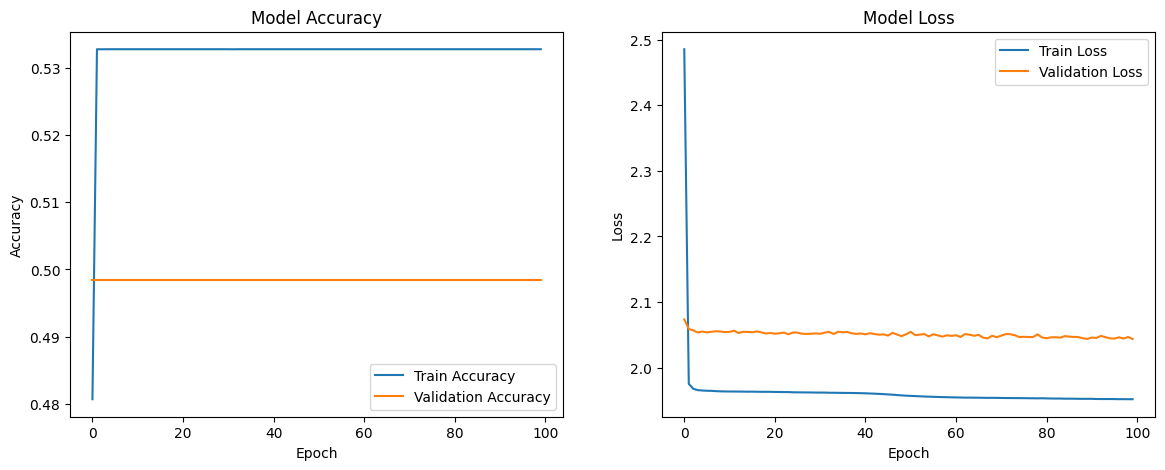

In [94]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# RNN 3

In [96]:
rnn_cols = df.drop(["fecha_hecho"], axis=1).columns

X = df.drop(['fecha_hecho', 'tipo_delito', 'delito', 'categoria_delito', 'IDS_AdecEnergetica', 'IDS_SeguridadSocial',
             'IDS_BienesDurables', 'IDS_Telecomunicaciones', 'IDS_Salud', 'IDS_AdecSanitaria'], axis=1)
y = df['tipo_delito']

encoder = OneHotEncoder(sparse_output=False)  # Use a single encoder for both sets
encoder.fit(y.values.reshape(-1, 1))

# 70% de los datos (2020-2024) para el entrenamiento
train_len = int(round(df.shape[0] * .7,0))

time_steps = 12

# Se experimenta con datos temporales y sociodemográficos de las alcaldías
X_train = X.iloc[:train_len][["es_fin_de_semana", "year", "Poblacion", "IDS_Educacion", "Estado_IDS"]]
y_train = y.iloc[:train_len]
X_test = X.iloc[train_len:][["es_fin_de_semana", "year", "Poblacion", "IDS_Educacion", "Estado_IDS"]]
y_test = y.iloc[train_len:]

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.values.reshape(-1, 1))
y_train_one_hot = encoder.transform(y_train.values.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.values.reshape(-1, 1))

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).reshape(-1, X_train.shape[-1])
X_test_scaled = scaler.transform(X_test).reshape(-1, X_test.shape[-1])

print(f"Original length of training data: {len(X_train)}, {len(y_train)}")
X_train_rnn, y_train_rnn = create_dataset(X_train_scaled, y_train_one_hot, time_steps)
print(f"Final length of training data: {len(X_train_rnn)}, {len(y_train_rnn)}")

print(f"\nOriginal length of test data: {len(X_test)}, {len(y_test)}")
X_test_rnn, y_test_rnn = create_dataset(X_test_scaled, y_test_one_hot, time_steps)
print(f"Final length of training data: {len(X_test_rnn)}, {len(y_test_rnn)}")

# Se revisan los valores de cada y
print("\nUnique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

# 70% de los datos (2020-2024) para el entrenamiento
split_index = int(0.7 * len(X_train_rnn))

X_train_split = X_train_rnn[:split_index]
y_train_split = y_train_rnn[:split_index]

X_val = X_train_rnn[split_index:]
y_val = y_train_rnn[split_index:]

Original length of training data: 138016, 138016
Final length of training data: 138016, 138016

Original length of test data: 59150, 59150
Final length of training data: 59150, 59150

Unique values in y_train: [  1   2   3   4   5   6   8   9  10  12  15  16  17  19  20  22  23  24
  25  28  29  30  33  34  35  36  39  40  44  45  46  47  48  49  50  51
  52  54  57  59  61  63  64  66  67  68  70  71  72  76  77  81  82  84
  85  87  89  90  91  92  95  96  98 101 102 103 105 106]
Unique values in y_test: [  1   2   3   4   5   6   8  10  12  15  16  19  20  21  22  23  24  25
  27  28  29  30  32  33  34  35  37  38  39  41  42  43  45  46  47  48
  49  50  51  52  53  54  59  60  61  63  64  65  66  67  68  69  70  71
  72  73  75  76  77  79  80  82  84  87  88  89  90  91  92  94  95  96
  97  98  99 101 102 103 105 106 107]


In [98]:
features = X_train_rnn.shape[2]
model = create_RNN(hidden_units=3, dense_units=y_train_one_hot.shape[1],
                   input_shape=(time_steps, features), activation=['tanh', 'softmax'])
history = model.fit(X_train_split, y_train_split, epochs=100, batch_size=64, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.4151 - loss: 3.1601 - val_categorical_accuracy: 0.4985 - val_loss: 2.0720
Epoch 2/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5357 - loss: 1.9678 - val_categorical_accuracy: 0.4985 - val_loss: 2.0592
Epoch 3/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5342 - loss: 1.9673 - val_categorical_accuracy: 0.4985 - val_loss: 2.0563
Epoch 4/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - categorical_accuracy: 0.5319 - loss: 1.9647 - val_categorical_accuracy: 0.4985 - val_loss: 2.0509
Epoch 5/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5312 - loss: 1.9674 - val_categorical_accuracy: 0.4985 - val_loss: 2.0519
Epoch 6/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_accuracy: 0.5325 - loss: 1.9639 - val_categorical_accuracy: 0.4985 - val_loss: 2.0523
Epoch 7/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - categorical_a

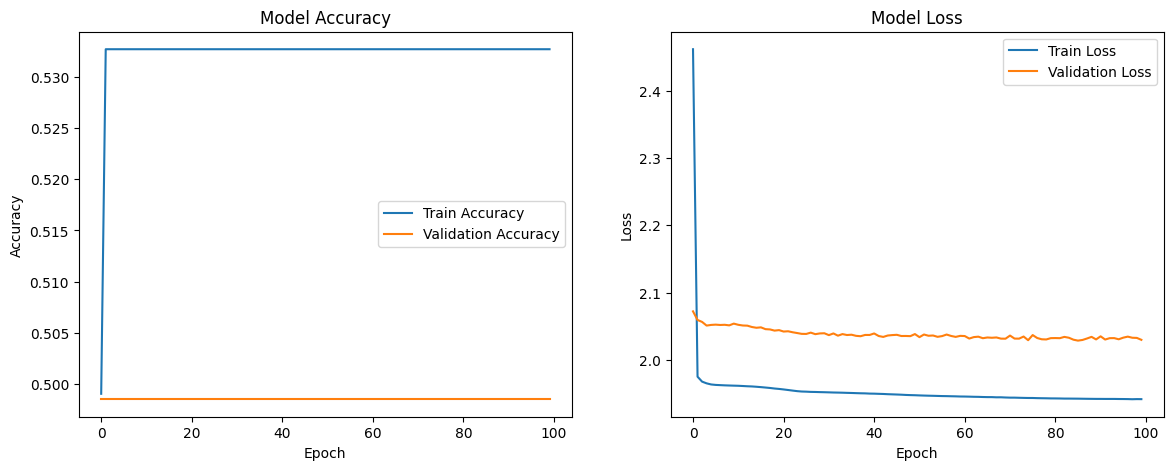

In [99]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()